<a href="https://colab.research.google.com/github/MThwa/crypto-analytics/blob/main/dungeonsPlayedTogether.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.auth import default
from datetime import datetime
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# get big query access
credentials, project = default()
client = bigquery.Client(credentials=credentials, project=project)

In [ ]:
# get usernames
users = client.query('''
  select
  to_hex(sha256(id)) user_id,
  username
  from openloot-362008.postgres_rds_auth_api_public.users
''').to_dataframe()

# get dungeon table
df = client.query('''
  select
  *
  from bigtimestudios.PlayerAnalytics.total_dungeons_data
  where event_date > date_sub(current_date(), interval 30 day)
''').to_dataframe()

df['event_date'] = pd.to_datetime(df['event_date'])
df.head()

# get token transactions

tokens = client.query('''
  select
  user_id,
  c.username,
  to_hex(sha256(user_id)) ga_id,
  sum(amount) bigtimeGrants
  from openloot-362008.postgres_rds_public.token_transactions a
  left join openloot-362008.postgres_rds_public.tokens b on a.token_id=b.id
  left join openloot-362008.postgres_rds_auth_api_public.users c on a.user_id=c.id
  where a.status='completed'
  and action='grant'
  and token_id = 'a07b874f-d30a-41d5-bfb1-879abf474590'  --$BIGTIME
  and date(a.created_at) >= date_sub(current_date(), interval 30 day)
  group by 1,2,3
  ''').to_dataframe()


In [ ]:
# last 30 days of data
df_recent = df[df['event_date'] > (datetime.now() - pd.Timedelta(days=30))]

# narrow it down to Regular and Prestige Portals (Avoids PPU and PvP)
df_recent = df_recent[df_recent['PortalType'].isin(['Portal', 'PrestigePortal']) == True]

# turn dataframe long
dungeon_long = pd.melt(
    df_recent,
    id_vars='DungeonInstanceGUID',
    value_vars=[f'GCO_PartyMember_{i}_OpenLootIDSHA256' for i in range(24)],
    var_name='PartySlot',
    value_name='PartyMember'
).dropna()

# rename the columns of the dungeon completions together
dungeon_name = pd.merge(dungeon_long, users, left_on='PartyMember', right_on='user_id', how='left')
dungeon_name = dungeon_name[['DungeonInstanceGUID','username']]

In [ ]:
# find out how many dungeons users completed together
pair_count = []

for dungeon_id, group in dungeon_name.groupby('DungeonInstanceGUID'):

  # find all unique combinations of dungeons
  members = group['username'].unique()
  pairs = list(combinations(sorted(members), 2)) # creates every possible two pairs of users (order agnostic)

  # add unique combinations to the initialized list
  pair_count.extend(pairs)

# rename columns
pair_df = pd.DataFrame(pair_count, columns=['Member1', 'Member2'])
pair_summary = pair_df.value_counts().reset_index(name='DungeonsCompletedTogether')

# establish minimum cutoff
dungeons_cutoff = 2
pair_summary_lim =  pair_summary[pair_summary['DungeonsCompletedTogether'] > dungeons_cutoff]

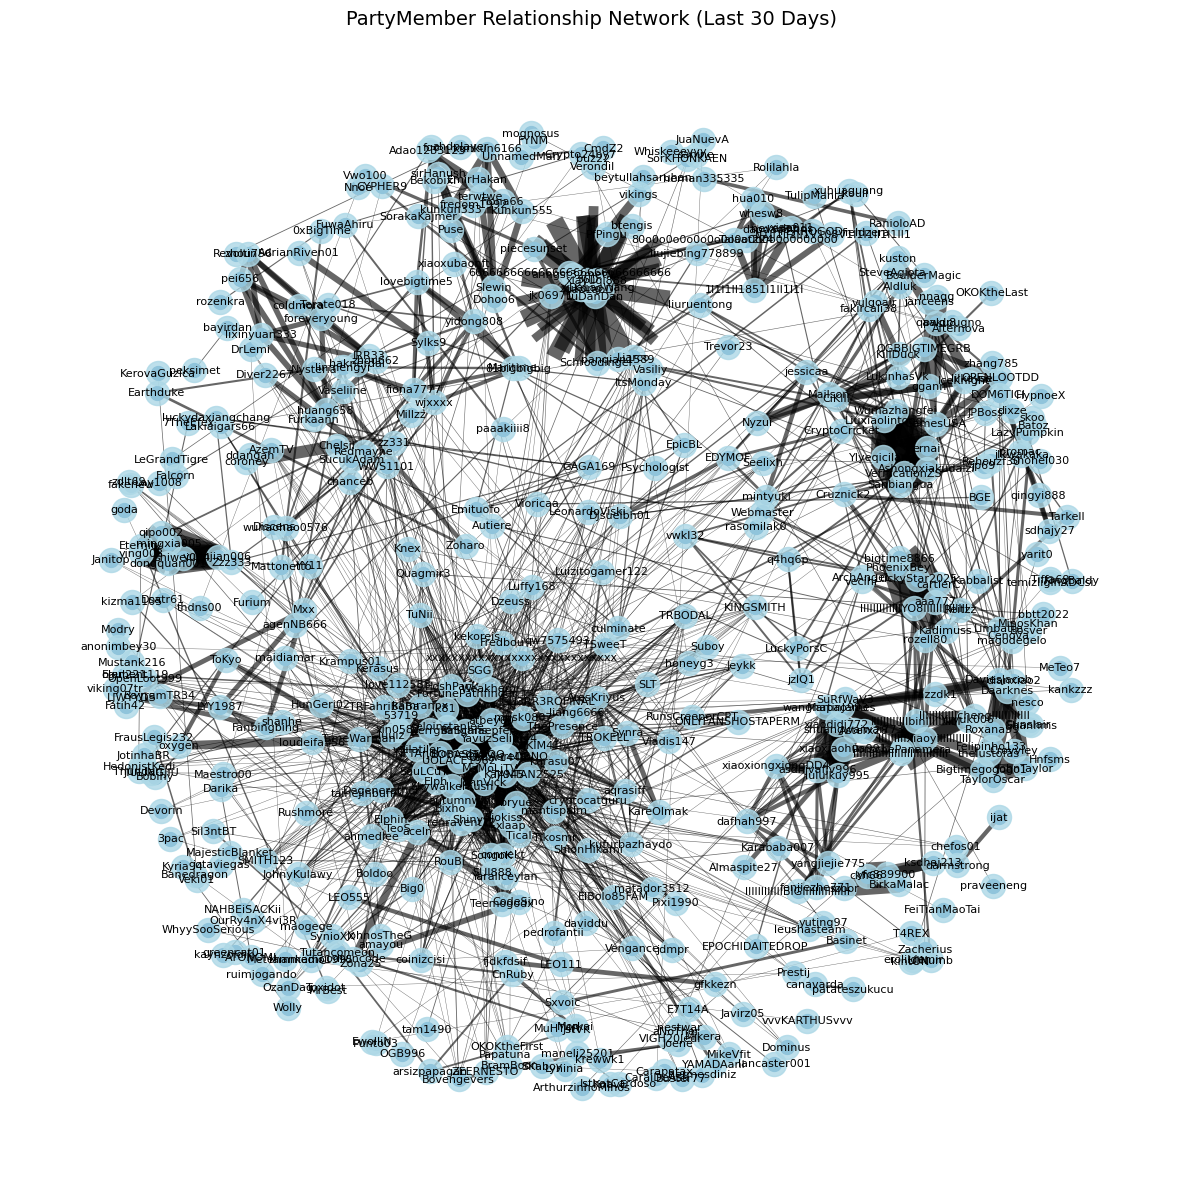

In [ ]:
# create network map
G = nx.Graph()

for _, row in pair_summary_lim.iterrows():
  G.add_edge(row['Member1'], row['Member2'], weight=row['DungeonsCompletedTogether'])

# create graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1, seed=20)

# weights given by number of dungeons completed together
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=100)

# Draw the graphs
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, width=[w*0.1 for w in weights], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('PartyMember Relationship Network (Last 30 Days)', fontsize=14)
plt.axis('off')
plt.show()

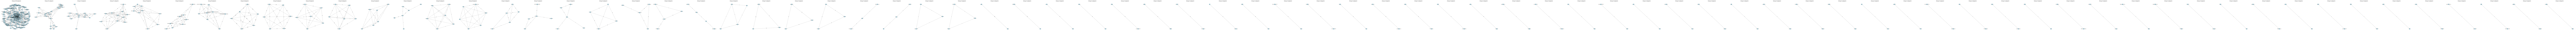

In [ ]:
# get connected components (each separate group of players)
components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
components = sorted(components, key=len, reverse=True)

# one subplot per connected component
n = len(components)
fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
if n == 1:
    axes = [axes]

for ax, subgraph in zip(axes, components):
    # Layout for consistent spacing
    pos = nx.spring_layout(subgraph, k=1.2, seed=42)

    # Draw base network
    nx.draw_networkx_nodes(subgraph, pos, ax=ax, node_size=300, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

    # Add edge labels (number of dungeons completed together)
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7, ax=ax)

    ax.set_title(f'Group ({len(subgraph.nodes)} players)')
    ax.axis('off')

plt.tight_layout()
plt.show()

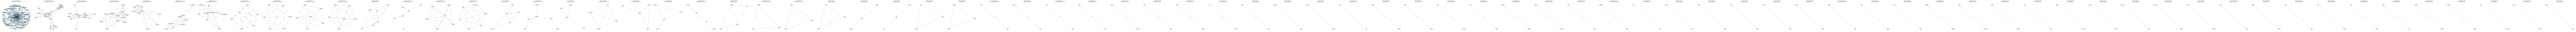

In [ ]:
# Assume `tokens` has columns: 'username' and 'bigtimeGrants'
# Make sure usernames match the graph's node names
tokens_dict = dict(zip(tokens['username'], tokens['bigtimeGrants']))

# get connected components
components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
components = sorted(components, key=len, reverse=True)

# plot one subplot per component
n = len(components)
fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
if n == 1:
    axes = [axes]

for ax, subgraph in zip(axes, components):
    pos = nx.spring_layout(subgraph, k=1.2, seed=42)

    # draw nodes and edges
    nx.draw_networkx_nodes(subgraph, pos, ax=ax, node_size=300, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(subgraph, pos, ax=ax, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(subgraph, pos, ax=ax, font_size=8)

    # edge labels (optional)
    edge_labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=7, ax=ax)

    # calculate total $BIGTIME for this group
    group_total = sum(tokens_dict.get(node, 0) for node in subgraph.nodes)

    # title includes both player count and total tokens
    ax.set_title(f'Group ({len(subgraph.nodes)} players)\nTotal $BIGTIME: {group_total:,.2f}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# print the members of each group
for i, subgraph in enumerate(components, start=1):
    members = list(subgraph.nodes())
    print(f"Group {i} ({len(members)} players): {members}")

Group 1 (220 players): ['Yaraliceylan', 'RouBi', 'Pixi1990', 'haknerdal', 'Tutancomeon', 'Shinyy', 'Joene', 'DrLemi', 'Crypto24by7', 'skoo', 'saligaris', 'godruncode', 'paaakiiii8', 'JotinhaBR', 'zdlt69', 'FuwaAhiru', 'honeyg3', 'Maestro00', 'SouLCuT', 'kufurbazhaydo', 'Elphin', 'Zona25', 'xiaoxubaonft', 'shanhe', 'AdrianRiven01', 'Prestij', 'chefos01', 'FortunePathfinder', 'kekoreis', 'Bixho', 'Synra', 'jotaviegas', 'Degenerathor', 'jessicaa', 'taihejinbuff', 'voilatiler', 'musk0807', '7TheEfex', 'kamranpx', 'janceens', 'Dzeuss', 'luuiz', 'lancaster001', 'ahmedlee', 'TeoS', 'SkywalkerKush', '0xBigTime', 'oxygen', 'Bobiny', 'HoshPack', 'Rehouzf30', 'Reitzz', 'OGB996', 'Vasiliy', 'Hnfsms', 'TRFahriBaBa', 'GU3RR3ROFINAL', 'Vengance', 'jk06971', 'Sylks9', 'jp69', 'Daarknes', 'ElBolo85FAM', 'Discens', 'ToKyo', 'pedrofantii', 'YIKIM41', 'fakenew', 'SorKHONKAEN', 'vulgoajr', 'ShionHikami', 'erolildemir', 'bryue', 'HedonistKedi', 'Rolilahla', 'seloinstanlee', 'Buster77', 'Fredbou', 'ogul221',